# Part I : Data Collection - REE API

The objective of this session is to understand how data can be retrieved from specific sources as REE API.

To do so, we will use `requests` library and `json` libraries for Python. These libraries are very famous and common python libraries to deal with http request and json file serialization.

Later on, we will use specific libraries for plotting as `matplotlib` and `datetime`.

In [1]:
# import requests library
import numpy as np
import requests 
import json
# import plotting library
import matplotlib
import matplotlib.pyplot as plt 
from datetime import date, datetime, timedelta


### Create the request

As we have seen before, when we work with APIs, we have to know and hold the URL of the exposed **endpoint** of the server where the information we want is stored. We have to start writing the whole http request to be made. Following concepts explained in class, this will include: an http method, the desired endpoint, headers and parameters.
Reading the available API documentation (mandatory) available here https://www.ree.es/es/apidatos you can understand that only GET request can be done.

Let's therefore write in our script the desired headers/parameters.
We need to write also the folder/section we want to access. Note that we can have the same endpoint but different sections from where to get the information. 

Most of the times, we need to add some headers to our requests that are required to get the information. The most important one is the **Authorization**, which corresponds to our ID to access that API. 

The following code is created only to facilitate the process of the API request generation. Endpoints, archives and headers are always provided in the API documentation, which have to be read.

In [2]:
endpoint = 'https://apidatos.ree.es'
get_archives = '/en/datos/mercados/precios-mercados-tiempo-real'
headers = {'Accept': 'application/json',
           'Content-Type': 'application/json',
           'Host': 'apidatos.ree.es'}
params = {'start_date': '2022-10-14T00:00', 'end_date': '2022-10-16T23:00', 'time_trunc':'hour'}

We are now looking at data regarding the **precios-mercados-tiempo-real** (look at the request archive above). We will find out what this archives contains once we have transferred the data.


We can write now the request according to the `requests` library and its `get` method. That is how you create a GET HTTP method with this library, which is very intuitive and easy to use.

In [3]:
response = requests.get(endpoint+get_archives, headers=headers, params=params)

After that, we can check if the request is correct or not according to the response we get from the API. 

In [4]:
response

<Response [200]>

In this case, the response we get is **200**, meaning that is has been accepted and the connection is established. 
There are different codes that tell us which is our connection status between us and the API. Please, have a look yourself at the possible outcomes of http request. 

In [5]:
status = response.status_code

#Check the status code
if status < 200:
    print('informational')
    # If the status code is 200, treat the information.
elif status >= 200 and status < 300:
    print('Connection is established')
    #okBehavior(response) # runs the function to get list of archives
elif status >= 300 and status < 400:
    print('redirection')
elif status >= 400 and status < 500:
    print('client error')
else:
    print('server error')

Connection is established


### Access the data

The data can be accessed by means of a json file. By calling the `json` method, we can access and store the transferred data. Have a look at all the IDs available for us to obtain data. 

In [6]:
# accessing data by means of a json object
json = response.json()

In [7]:
#json

For a better visualization of the json content, you can use this tool (https://jsonformatter.curiousconcept.com). This helps in understanding the structure of the json file and access the desired data.
You can find out using the suggested tool that the response to the request contain the desired substructures.

The **data** struct contains details about your request.
The **included** struct contains the actual data. It contains an additional substructure ("Precio mercado spot" or "Spot market price"). 
Let's try to extract the **Spot market price** (€/MWh). The spot market price can be also called the "Day-Ahead Market" price (DAM) which is contracted the same day for the next one. Prices are defined for each hour.


To access the actual values it is needed to access some more substructures ("attributes" and "values")

In [8]:
spot_market_prices = json['included'][1]
PVPC_prices = json['included'][0]
values = spot_market_prices['attributes']['values']


### Store the data locally

Create local structure in your python environment and fill them with data

In [10]:
prices = []
hours = []

In [11]:
for time_period in values:
    #print(time_period['value'])
    prices.append(time_period['value'])
    hours.append(time_period['datetime'])
    #print(f"Price at {time_period['datetime']} is {time_period['value']} €/MWh")

Now that is what we have

In [12]:
len(prices)

72

In [13]:
len(hours)

72

### Plot the spot market price - DAM price

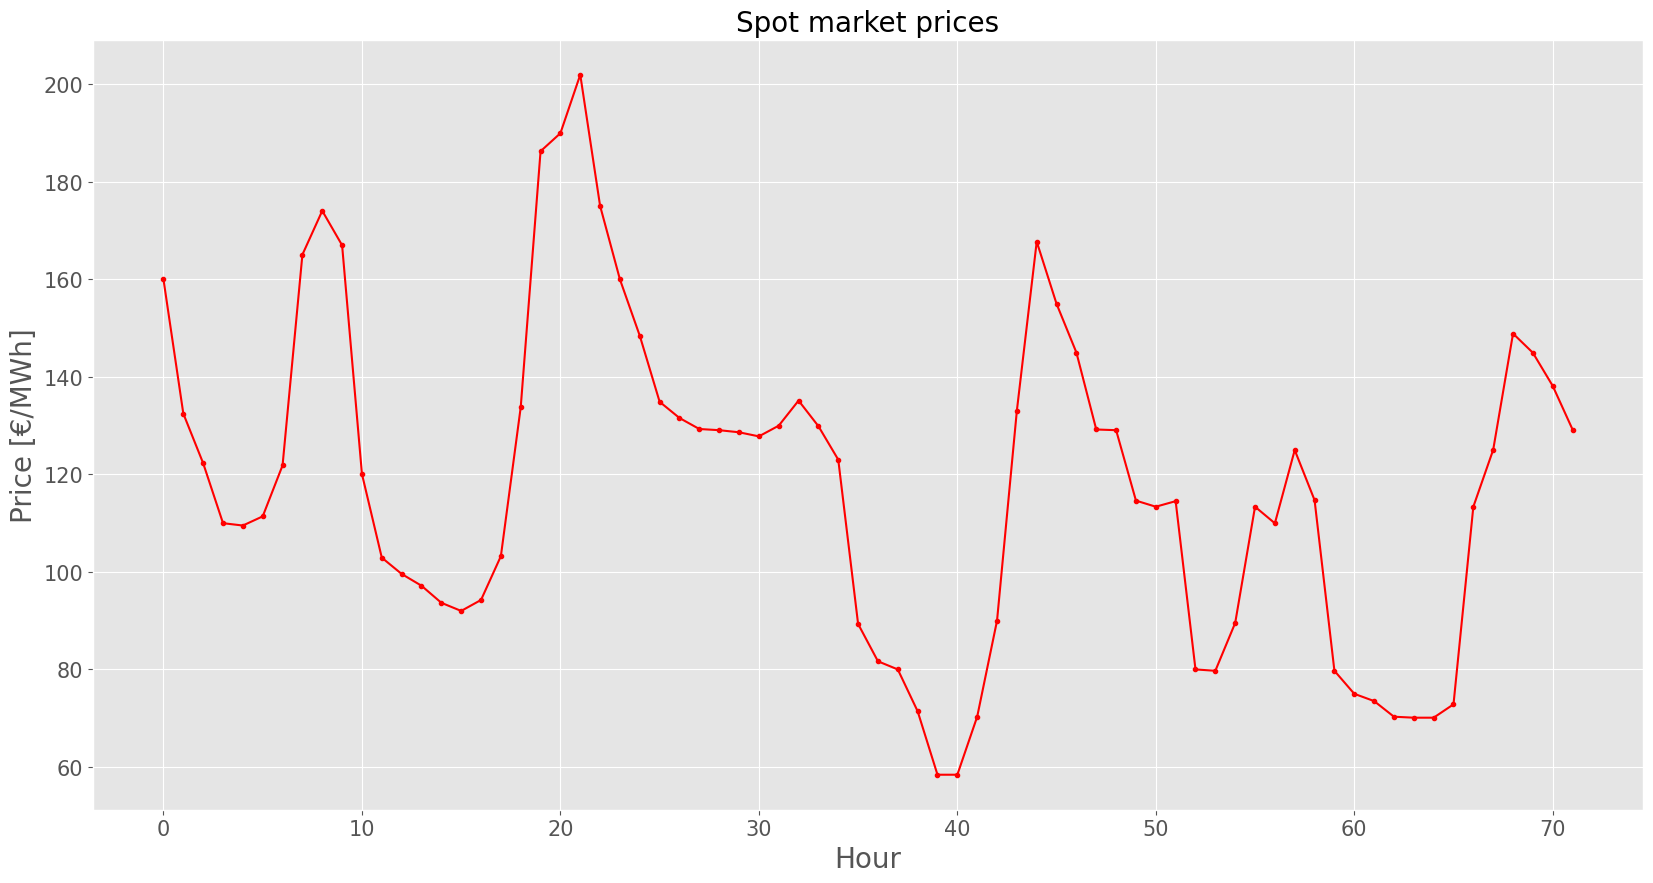

In [14]:
matplotlib.rc('xtick', labelsize=15)     
matplotlib.rc('ytick', labelsize=15)

plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.plot(prices,'r', linewidth=1.5, marker='.')
plt.title(f"Spot market prices", fontsize=20)
plt.xlabel('Hour', fontsize=20 )
plt.ylabel('Price [€/MWh]', fontsize=20)
plt.show()

### Changing Dates

We could try to change the dates and ask for more recent prices. Let's make a new request, changing the desired parameters:

In [15]:
params = {'start_date': '2022-10-14T00:00', 'end_date': '2022-10-14T23:00', 'time_trunc':'hour'}

In [16]:
response = requests.get(endpoint+get_archives, headers=headers, params=params)

In [17]:
response

<Response [200]>

Let's repeat the process of extracting the data in a new structure (without plotting for brevity)

In [18]:
json_new = response.json()

In [19]:
spot_market_prices_new = json_new['included'][0]
values_new = spot_market_prices_new['attributes']['values']

In [20]:
prices_new = []
hours_new = []
for time_period in values_new:
    prices_new.append(time_period['value'])
    hours.append(time_period['datetime'])

Let's plot and compare the new data

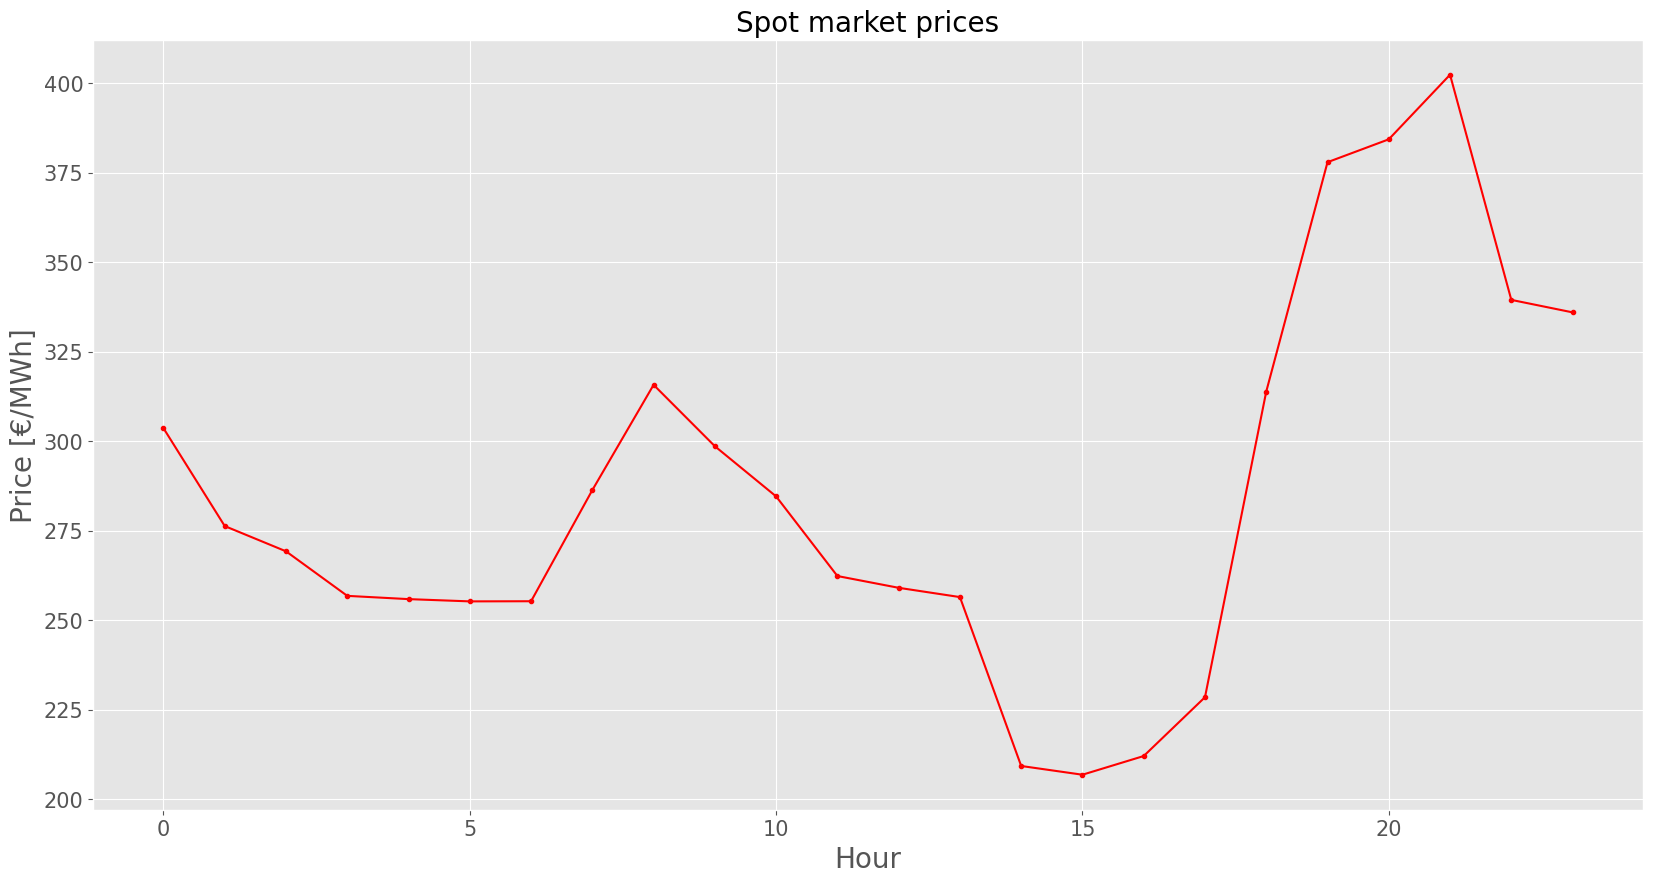

In [21]:
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.plot(prices_new, 'r', linewidth=1.5, marker='.')
plt.title(f"Spot market prices", fontsize=20)
plt.xlabel('Hour', fontsize=20 )
plt.ylabel('Price [€/MWh]', fontsize=20)
plt.show()

Now you understand why recently people are going crazy to pay their bills! :) 

Let's look for the most updated price signals.
We need to use teh python `datetime` library for this. The approach is to generate the actual time in UTC time coordinates and add the desired time step for the analysis. Spot market prices are generated today for tomorrow and are available from 12PM when the market closes. If you are running the code after your 12PM you should be able to see DAM prices for tomorrow.

Mind that datetime objects have to be transformed into strings, follwing the required format specified in the parameters of the API documentation, otherwise it will not work.

In [22]:
start_date = datetime.utcnow()
end_date = start_date + timedelta(hours=24)             # add one day to see prices for tomorrow
# transform into strings with a minute resolution
end_date = end_date.strftime('%Y-%m-%dT%H:%M')
start_date = start_date.strftime('%Y-%m-%dT%H:%M')
# check
end_date


'2022-11-23T10:48'

In [23]:
start_date

'2022-11-22T10:48'

Update the parameters of the API request with the new structures

In [24]:
params = {'start_date': start_date, 'end_date': end_date, 'time_trunc':'hour'}
response = requests.get(endpoint+get_archives, headers=headers, params=params)
response

<Response [200]>

Extract values just as before

In [25]:
data_json = response.json()
data_json

{'data': {'type': 'Precios mercado peninsular en tiempo real',
  'id': 'mer13',
  'attributes': {'title': 'Precios mercado peninsular en tiempo real',
   'last-update': '2022-11-21T20:17:33.000+01:00',
   'description': None},
  'meta': {'cache-control': {'cache': 'MISS'}}},
 'included': [{'type': 'PVPC (€/MWh)',
   'id': '1001',
   'groupId': None,
   'attributes': {'title': 'PVPC (€/MWh)',
    'description': None,
    'color': '#ffcf09',
    'type': None,
    'magnitude': 'price',
    'composite': False,
    'last-update': '2022-11-21T20:17:33.000+01:00',
    'values': [{'value': 161.55,
      'percentage': 0.7088013338013338,
      'datetime': '2022-11-22T11:00:00.000+01:00'},
     {'value': 156.41,
      'percentage': 0.7138423622837844,
      'datetime': '2022-11-22T12:00:00.000+01:00'},
     {'value': 153.19,
      'percentage': 0.7168795919322383,
      'datetime': '2022-11-22T13:00:00.000+01:00'},
     {'value': 108.46,
      'percentage': 0.6362783057608824,
      'datetime': 

You might have notice that the structure of the json output has changed now. A new field appeared: **PVPC** (Voluntary price for the small consumer - Precio Voluntario Pequeno Consumidor - €/MWh) which the final cost of energy for the consumer taken into account the intraday market and other factors such as dispatching and adjustment services.

This changes do happen a lot in APIs, because as said they have their own software development cycle (ciclically need maintaince) and might be subjected to change. Do always check out the API documentation to keep trace of the changes.
API are not perfect tools :) and might contain bugs, missing data, and many more...

Let's extract the data we have


In [26]:
spot_price = data_json["included"][1]["attributes"]["values"][0]["value"]
time_str = data_json["included"][1]["attributes"]["values"][0]["datetime"]
# from string to datetime
time = datetime.strptime(time_str[:16], '%Y-%m-%dT%H:%M') 
print(f"Spot market price at {time} is {spot_price} €/MWh")

Spot market price at 2022-11-22 11:00:00 is 66.37 €/MWh


In [27]:
pvpc = data_json["included"][0]["attributes"]["values"][0]["value"]
time_str = data_json["included"][0]["attributes"]["values"][0]["datetime"]
# from string to datetime
time = datetime.strptime(time_str[:16], '%Y-%m-%dT%H:%M') 
print(f"Price the final consumer is paying at {time} is {pvpc} €/MWh")

Price the final consumer is paying at 2022-11-22 11:00:00 is 161.55 €/MWh


As you can see there is a big difference between the price settled by the spot market and the price that the final consumer is paying!

# Part II: Exercize

### Build your own request to the REE API

Looking at the REE API documentation available online, you can see the several information available (called "widget").
Each widget belong to a category. Pick the one of your interest and try to stream the desired data from the REE API.
You would need to set proper parameters for each widget.
It is important to have a deep look at the API documentation, looking for the type of information that might be of interest for you.

Set your own request parameters here below:

In [28]:
endpoint = 'https://apidatos.ree.es'
get_archives = '/en/datos/generacion/estructura-generacion'
headers = {'Accept': 'application/json',
           'Content-Type': 'application/json',
           'Host': 'apidatos.ree.es'}
#params = 'start_date=2022-11-17T00:00&end_date=2022-01-18T23:59&time_trunc=hour'

Now you can make your own request

In [29]:
params = {'start_date': '2021-11-14T00:00', 'end_date': '2021-11-16T23:00', 'time_trunc':'month'}
response = requests.get(endpoint+get_archives, headers=headers, params=params)


Check the status of your request

In [30]:
response

<Response [200]>

Problem with your request? meaning any status different than 200.
Check the problem related with your request and try to fix it. Use the following:

In [31]:
response.json()

{'data': {'type': 'Generation structure by technology',
  'id': 'gen1',
  'attributes': {'title': 'Generation structure by technology',
   'last-update': '2022-11-10T20:21:12.000+01:00',
   'description': None},
  'meta': {'cache-control': {'cache': 'HIT',
    'expireAt': '2022-12-22T09:44:57'}}},
 'included': [{'type': 'Hydro',
   'id': '10288',
   'groupId': '1',
   'attributes': {'title': 'Hydro',
    'description': None,
    'color': '#0090d1',
    'type': 'Renovable',
    'magnitude': None,
    'composite': False,
    'last-update': '2022-11-10T20:21:02.000+01:00',
    'values': [{'value': 99052.855,
      'percentage': 0.043690485068942665,
      'datetime': '2021-11-01T00:00:00.000+01:00'}]}},
  {'type': 'Pumped storage',
   'id': '1445',
   'groupId': '1',
   'attributes': {'title': 'Pumped storage',
    'description': None,
    'color': '#007cf9',
    'type': 'No-Renovable',
    'magnitude': None,
    'composite': False,
    'last-update': '2022-01-11T10:26:24.000+01:00',
    

Change parameters accordingly.



When your connection is succesfully established. Access the data by means of a json object

In [32]:
json = response.json()
json

# type code here to extract data

{'data': {'type': 'Generation structure by technology',
  'id': 'gen1',
  'attributes': {'title': 'Generation structure by technology',
   'last-update': '2022-11-10T20:21:12.000+01:00',
   'description': None},
  'meta': {'cache-control': {'cache': 'HIT',
    'expireAt': '2022-12-22T09:44:57'}}},
 'included': [{'type': 'Hydro',
   'id': '10288',
   'groupId': '1',
   'attributes': {'title': 'Hydro',
    'description': None,
    'color': '#0090d1',
    'type': 'Renovable',
    'magnitude': None,
    'composite': False,
    'last-update': '2022-11-10T20:21:02.000+01:00',
    'values': [{'value': 99052.855,
      'percentage': 0.043690485068942665,
      'datetime': '2021-11-01T00:00:00.000+01:00'}]}},
  {'type': 'Pumped storage',
   'id': '1445',
   'groupId': '1',
   'attributes': {'title': 'Pumped storage',
    'description': None,
    'color': '#007cf9',
    'type': 'No-Renovable',
    'magnitude': None,
    'composite': False,
    'last-update': '2022-01-11T10:26:24.000+01:00',
    

Store the data in local python structures

In [33]:
# type code here
gen_type = []#'Renovable']
gen_MWh = []#0]
for gen_t in json['included']:
    if gen_t['attributes']['title'] == 'Total generation':
        total_generation = gen_t['attributes']['values'][0]['value']
    #elif gen_t['attributes']['type'] == 'Renovable':
        #print(gen_t['attributes']['title'] + ' is renewable')
        #gen_MWh[0] += float(gen_t['attributes']['values'][0]['value'])
    else:
    #print(gen_t['attributes'])
    #print(gen_t['attributes']['values'][0]['value'])
        gen_type.append(gen_t['attributes']['title'])
        gen_MWh.append(gen_t['attributes']['values'][0]['value'])


Print the data for better visualization and analysis

In [34]:
for i in range(len(gen_type)):
    print(gen_type[i], ':' , gen_MWh[i], 'MWh')
sum(gen_MWh)

Hydro : 99052.855 MWh
Pumped storage : 10420.255 MWh
Nuclear : 353777.612 MWh
Coal : 58275.467 MWh
Diesel engines : 21708.936 MWh
Gas turbine : 2861.847 MWh
Steam turbine : 11915.048 MWh
Combined cycle : 521310.424 MWh
Hydroeolian : 38.87 MWh
Wind : 710622.648 MWh
Solar photovoltaic : 164638.138 MWh
Thermal solar : 25686.656 MWh
Other renewables : 45617.879 MWh
Cogeneration : 215133.394 MWh
Non-renewable waste : 17625.752 MWh
Renewable waste : 8463.573 MWh


2267149.354

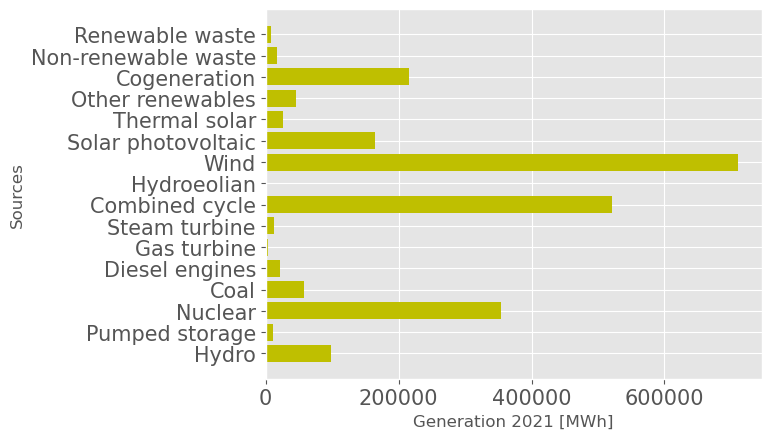

In [35]:
plt.barh(np.arange(len(gen_type)), gen_MWh, color='y')
plt.yticks(np.arange(len(gen_type)), gen_type)
plt.xlabel('Generation ' + str(json['included'][0]['attributes']['values'][0]['datetime'].split('-')[0]) +  ' [MWh]')
plt.ylabel('Sources')
plt.show() 

# Part III: Exercize

Going back to the Part 1 of the lab, take the most updated prices for the spot market and the PVPC and compare them in a chart. Draw some conclusions.

In [57]:
spot_arr = []
for hourly_value in spot_market_prices['attributes']['values']:
    spot_arr.append(hourly_value['value'])

In [58]:
len(spot_arr)

72

In [59]:
PVPC_arr = []
for hourly_value in PVPC_prices['attributes']['values']:
    PVPC_arr.append(hourly_value['value'])

In [60]:
len(PVPC_arr)

72

In [62]:
for day in range(3):
    for hour in range(24):
        print('Hour: ' + str(hour), ' // Price PVPC: ' +str(PVPC_arr[day*24+hour]), ' // Price Spot: ' +str(spot_arr[day*24+hour]))

Hour: 0  // Price PVPC: 303.61  // Price Spot: 160
Hour: 1  // Price PVPC: 276.28  // Price Spot: 132.48
Hour: 2  // Price PVPC: 269.23  // Price Spot: 122.3
Hour: 3  // Price PVPC: 256.79  // Price Spot: 110
Hour: 4  // Price PVPC: 255.88  // Price Spot: 109.52
Hour: 5  // Price PVPC: 255.25  // Price Spot: 111.4
Hour: 6  // Price PVPC: 255.29  // Price Spot: 121.85
Hour: 7  // Price PVPC: 286.33  // Price Spot: 165.09
Hour: 8  // Price PVPC: 315.72  // Price Spot: 174.08
Hour: 9  // Price PVPC: 298.58  // Price Spot: 167.02
Hour: 10  // Price PVPC: 284.56  // Price Spot: 120.09
Hour: 11  // Price PVPC: 262.33  // Price Spot: 102.93
Hour: 12  // Price PVPC: 259.04  // Price Spot: 99.59
Hour: 13  // Price PVPC: 256.45  // Price Spot: 97.17
Hour: 14  // Price PVPC: 209.28  // Price Spot: 93.67
Hour: 15  // Price PVPC: 206.84  // Price Spot: 92
Hour: 16  // Price PVPC: 212.06  // Price Spot: 94.25
Hour: 17  // Price PVPC: 228.49  // Price Spot: 103.23
Hour: 18  // Price PVPC: 313.85  // 

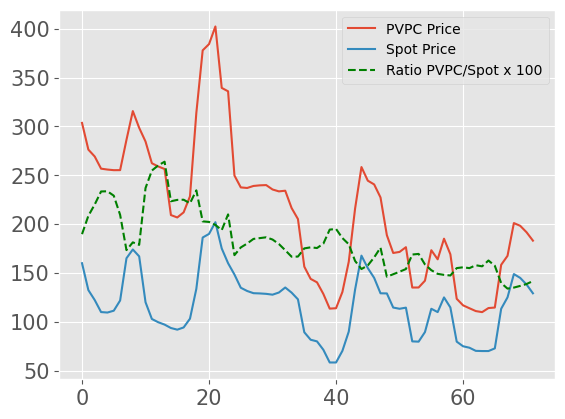

In [95]:
plt.plot(np.arange(72), PVPC_arr, label='PVPC Price')
plt.plot(np.arange(72), spot_arr, label='Spot Price')
plt.plot(np.arange(72), [i / j * 100 for i, j in zip(PVPC_arr, spot_arr)], color = 'g', linestyle='--', label='Ratio PVPC/Spot x 100')
plt.legend()

Conclusions: 

The PVPC (Voluntary price for the small consumer) prices and the spot market prices are not the same. The green dashed line indicates the ratio between the PVPC price and the spot price. It varies slightly between 134 and 264

# Part IV: another Example

### Gather Day-Ahead Market Clearing Price with old REE API

Here follows another example of gathering data of the DAM price (Day Ahead Market clearing price - Precio mercado SPOT Diario), using the old version available of the API from REE. 
This is just an example to show you a different API syntax.


As you can see here, the API requires an authentication through a personal user token (available in the code lines). This API is however out-dated and no more in use. REE suggests to use the new open API.

Mind that you should consult the old API documentation available here (https://api.esios.ree.es/)

In [101]:
# select the indicator for market clearing (DAM) price (Precio mercado SPOT Diario)
indicator = str(600)    
# You can get it by putting the mouse over the indicator name on the webpage. 
# webpage: https://www.esios.ree.es/es/analisis/600
# NB: Imbalance indicator is 687

# start building the URL
website = 'https://api.esios.ree.es/indicators/'+indicator+'?start_date='+'2019-10-12T00:00:00.00'+'&end_date='+'2019-10-13T00:00:00.00'
URL = website # host website
GET = '/archives_json' # API link
HEADERS = {
            'Accept': "application/json; application/vnd.esios-api-v1+json",
            'Host': 'api.esios.ree.es',
            'Authorization': "Token token=\"a6f2f926dea90ade64acc97b3b4fff73af5bdc5d7bce554a1adfa16d554ede81",#"a6f2f926dea90ade64acc97b3b4fff73af5bdc5d7bce554a1adfa16d554ede81"',
            'Content-Type': 'application/json'}
#PARAMS = {'date':date}

# Runs the request to get the total URL with access token
response = requests.get(url = URL+GET, headers = HEADERS)#, params = PARAMS)

# Read the status code
status = response.status_code  

# extract the data in json format
json_data = response.json()


In [102]:
status

200

In [103]:
json_data

{'indicator': {'name': 'Precio mercado SPOT Diario',
  'short_name': 'Mercado SPOT',
  'id': 600,
  'composited': False,
  'step_type': 'linear',
  'disaggregated': True,
  'magnitud': [{'name': 'Precio', 'id': 23}],
  'tiempo': [{'name': 'Hora', 'id': 4}],
  'geos': [{'geo_id': 1, 'geo_name': 'Portugal'},
   {'geo_id': 2, 'geo_name': 'Francia'},
   {'geo_id': 3, 'geo_name': 'España'}],
  'values_updated_at': '2019-10-12T13:55:09.000+02:00',
  'values': [{'value': 47.1,
    'datetime': '2019-10-12T00:00:00.000+02:00',
    'datetime_utc': '2019-10-11T22:00:00Z',
    'tz_time': '2019-10-11T22:00:00.000Z',
    'geo_id': 1,
    'geo_name': 'Portugal'},
   {'value': 14.19,
    'datetime': '2019-10-12T00:00:00.000+02:00',
    'datetime_utc': '2019-10-11T22:00:00Z',
    'tz_time': '2019-10-11T22:00:00.000Z',
    'geo_id': 2,
    'geo_name': 'Francia'},
   {'value': 47.1,
    'datetime': '2019-10-12T00:00:00.000+02:00',
    'datetime_utc': '2019-10-11T22:00:00Z',
    'tz_time': '2019-10-11T22:

In [104]:
# Diving into the data:
marketlist = []
for stuff in response.json()["indicator"]['values']:
    #print(stuff) ## show more stuff that can be gathered
    if stuff['geo_id'] == 3: ## choose Espana. 1 = Portugal, 2 = Francia
    #print(stuff['value'])
        marketlist.append(stuff['value'])

# Print the data
print('\n')
print(f"List of market prices for day 2019-10-12 in €/MWh:")        
print(marketlist)





List of market prices for day 2019-10-12 in €/MWh:
[47.1, 44.63, 41.01, 38.7, 38.45, 37.6, 37.25, 38.0, 38.5, 42.27, 46.02, 40.37, 38.45, 37.1, 35.6, 30.04, 30.0, 30.74, 36.25, 44.65, 46.02, 46.05, 38.7, 37.89, 35.86]


C:\Users\JoseLuz\AppData\Local\Temp\ipykernel_31648\619974662.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(marketlist,'r',linewidth=3, color='cornflowerblue')


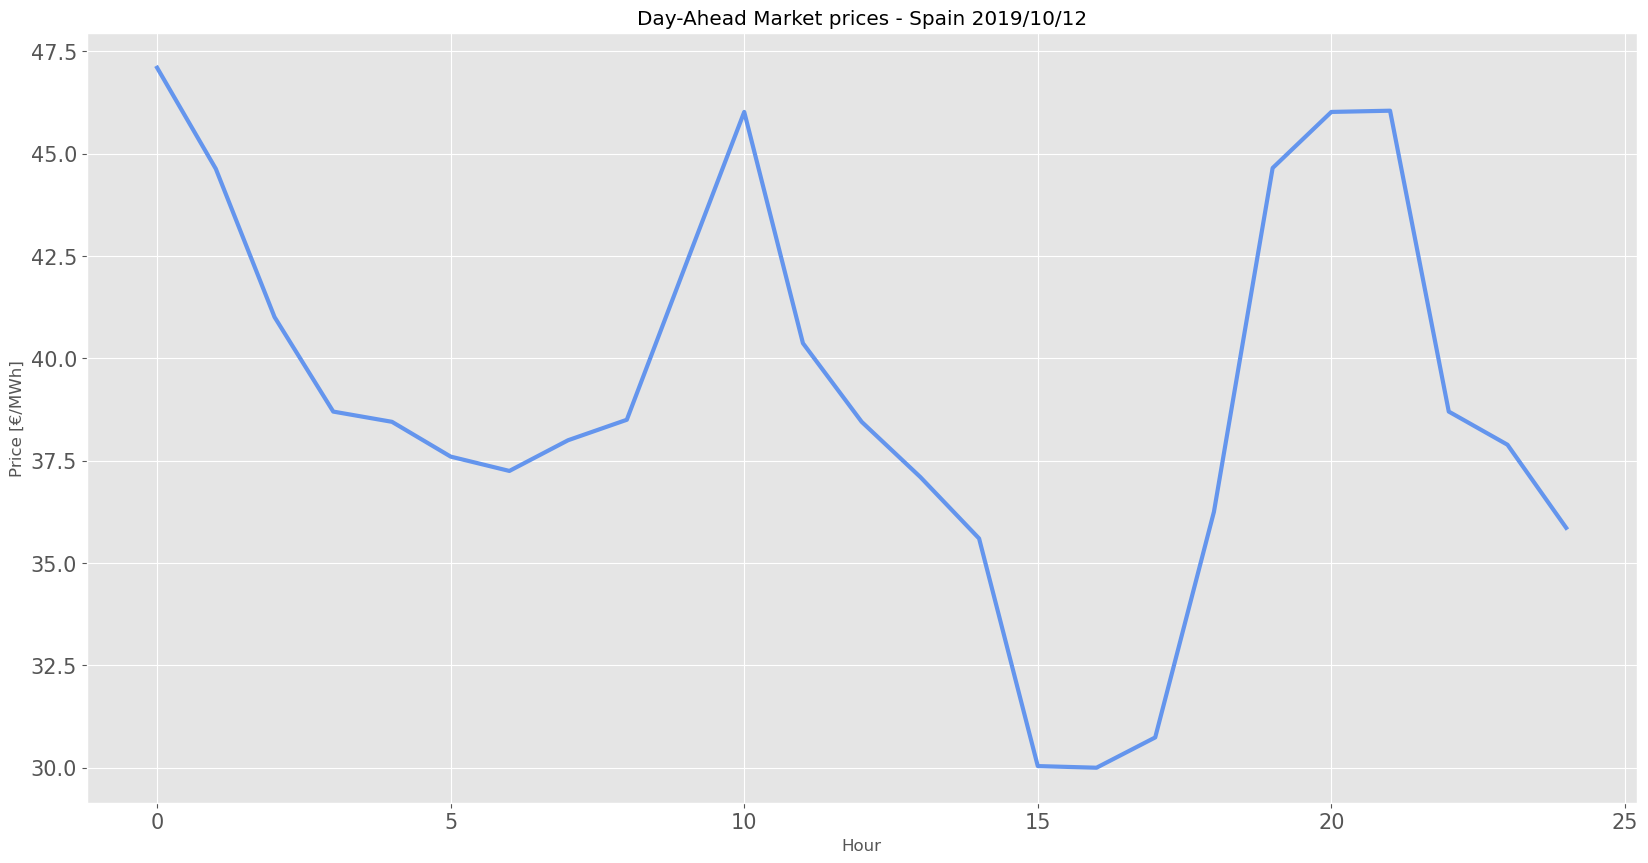

In [105]:
# Plot the data
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.plot(marketlist,'r',linewidth=3, color='cornflowerblue')
plt.title(f"Day-Ahead Market prices - Spain 2019/10/12")
#plt.xlim(0,24)
#plt.ylim(0,50)
plt.xlabel('Hour')
plt.ylabel('Price [€/MWh]')
plt.show()

Same code but now requesting recent dates. Remember, to gather the day-ahead market price (contracted today, but referred tomorrow) you have to ask to the API the date of tomorrow.

In [ ]:
date_today = date.today()                # use todays prices
date = date_today + timedelta(days=1)    # open to use tomorrows prices
#dateend = datetime.date.today()            # use to specify a date
dateend = date                              # to use only one day

startdate = str(date_today) + "T00:00:00.00" # can specify more if desired
enddate = str(dateend) + "T23:50:00.00"
     
print('Checking dates: ' , startdate , "to" , enddate) # printing the date 

In [ ]:
website = 'https://api.esios.ree.es/indicators/'+indicator+'?start_date='+startdate+'&end_date='+enddate
URL = website # host website
GET = '/archives_json' # API link
HEADERS = {
            'Accept': "application/json; application/vnd.esios-api-v1+json",
            'Host': 'api.esios.ree.es',
            'Authorization': "Token token=\"a6f2f926dea90ade64acc97b3b4fff73af5bdc5d7bce554a1adfa16d554ede81",#"a6f2f926dea90ade64acc97b3b4fff73af5bdc5d7bce554a1adfa16d554ede81"',
            'Content-Type': 'application/json'}
#PARAMS = {'date':date}

# Runs the request to get the total URL with access token
response = requests.get(url = URL+GET, headers = HEADERS)#, params = PARAMS)

# Read the status code
status = response.status_code 
status

json_data = response.json()
json_data

In [ ]:
# Diving into the data:
marketlist = []
for stuff in response.json()["indicator"]['values']:
    #print(stuff) ## show more stuff that can be gathered
    if stuff['geo_id'] == 3: ## choose Espana. 1 = Portugal, 2 = Francia
    #print(stuff['value'])
        marketlist.append(stuff['value'])

# Print the data
print('\n')
print(f"List of market prices for {date_today} in €/MWh:")        
print(marketlist)

# Plot the data
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.plot(marketlist,'r',linewidth=3, color='cornflowerblue')
plt.title(f"Day-Ahead Market prices for {date_today}")
plt.xlabel('Hour')
plt.ylabel('Price [€/MWh]')
plt.show()

# Part V: CO2 Signal API

This is a free to use API from the famous **electricitymap.org**.

You can use our API to get access to information about how much carbon is emitted when producing electricity in a country.
API documentation is available at https://docs.co2signal.com/#introduction

CO2 Signal uses API keys to allow access to the API. You can get an API key by making a request in their website.
CO2 Signal expects the API key to be included as a header in all requests to the server

### Get latest by country code

In [ ]:
my_api_token = '6XKOU4LnlqtA4eCwDvkzkkzIbXqoeI0D'

endpoint = 'https://api.co2signal.com'
get_archive = '/v1/latest'
headers = {'auth-token': my_api_token}
params = {'countryCode':'IT'} 

In [ ]:
response = requests.get(endpoint+get_archive, headers=headers, params=params)
response

In [ ]:
# extract the data in json format
json_data = response.json()
json_data

Looking both at the docs and at the json structure we can see we have 2 information available **carbon intensity** and **fossil fuel percentage** for the desired country at the latest time available.

In [ ]:
co2_intensity = json_data['data']['carbonIntensity']
ff_perc = json_data['data']['fossilFuelPercentage']
time_str = json_data['data']['datetime']
# from string to datetime
time = datetime.strptime(time_str[:16], '%Y-%m-%dT%H:%M') 

print(f"Details of energy production in country {params['countryCode']} at {time}")
print(f"Carbon Intensity: {co2_intensity}")
print(f"Fossil Fuel Percentage: {ff_perc}")

# Part VI: WeatherAPI.com

WeatherAPI.com is a powerful fully managed **free weather and geolocation API provider** that provides extensive APIs that range from the weather forecast, historical weather, future weather, weather alerts, air quality data, IP lookup, and astronomy through to sports, time zone, and geolocation.

The API can be found accessed in the popular API market place **RapidAPI** (https://rapidapi.com/weatherapi/api/weatherapi-com)

It is required to sign up with an account in RapidAPI to use the free API. When you did that you need to subscribe to a pricing plan for the API (the free one, of course). Take a look at the limited functionalities, you can access only a few endpoints. As you can see all of them allow for **GET** methods.

Once the subscription is active you can generate in an authomatic way the code for the request through the interface (very useful) and copypaste it to use it right away.

One of the endpoints available with the free subscription is the current weather. Let's check this out

In [ ]:
import requests

# chose the endpoint
url = "https://weatherapi-com.p.rapidapi.com/current.json"

# define the headers with the authorization token
headers = {"X-RapidAPI-Key": "6a425b2a7bmshc1f059e65b98fb7p1cdd78jsn184965114ca2",
           "X-RapidAPI-Host": "weatherapi-com.p.rapidapi.com"}

# define parameters as specified in the API documentation
querystring = {"q":"Barcelona","dt":"2022-12-25"}

#create the get request
response = requests.request("GET", url, headers=headers, params=querystring)

print(response.text)

You can now go on with the data extraction and post-processing of streaming data as you like

# Part VII: choose your desired API 

Connect to the RapidAPI website (https://rapidapi.com/hub) and take a free API of your choice and start experimenting. Have Fun! :)